In [37]:
!pip install wandb
!pip install pillow


In [38]:
import wandb

# API 키를 직접 입력하여 로그인
wandb.login(key='29deffe9c585c7df9856b1bb0306cf3365f482dc')


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [39]:
import os
import time
import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
import random


In [40]:
import timm

# 사용할 수 있는 모델 목록 확인
model_names = timm.list_models()
print(model_names)


['bat_resnext26ts', 'beit_base_patch16_224', 'beit_base_patch16_384', 'beit_large_patch16_224', 'beit_large_patch16_384', 'beit_large_patch16_512', 'beitv2_base_patch16_224', 'beitv2_large_patch16_224', 'botnet26t_256', 'botnet50ts_256', 'caformer_b36', 'caformer_m36', 'caformer_s18', 'caformer_s36', 'cait_m36_384', 'cait_m48_448', 'cait_s24_224', 'cait_s24_384', 'cait_s36_384', 'cait_xs24_384', 'cait_xxs24_224', 'cait_xxs24_384', 'cait_xxs36_224', 'cait_xxs36_384', 'coat_lite_medium', 'coat_lite_medium_384', 'coat_lite_mini', 'coat_lite_small', 'coat_lite_tiny', 'coat_mini', 'coat_small', 'coat_tiny', 'coatnet_0_224', 'coatnet_0_rw_224', 'coatnet_1_224', 'coatnet_1_rw_224', 'coatnet_2_224', 'coatnet_2_rw_224', 'coatnet_3_224', 'coatnet_3_rw_224', 'coatnet_4_224', 'coatnet_5_224', 'coatnet_bn_0_rw_224', 'coatnet_nano_cc_224', 'coatnet_nano_rw_224', 'coatnet_pico_rw_224', 'coatnet_rmlp_0_rw_224', 'coatnet_rmlp_1_rw2_224', 'coatnet_rmlp_1_rw_224', 'coatnet_rmlp_2_rw_224', 'coatnet_rmlp_2


1. **Lightweight MobileNets and GhostNets**:
   - `mobilenetv2_035`, `mobilenetv2_050`, `mobilenetv2_075`, `mobilenetv2_100`, `mobilenetv3_small_050`, `mobilenetv3_small_075`, `mobilenetv3_small_100`, `ghostnet_050`, `ghostnet_100`, `ghostnetv2_100`, `ghostnetv2_130`, `ghostnetv2_160`

2. **EfficientNets (Lite models)**:
   - `efficientnet_lite0`, `efficientnet_lite1`, `efficientnet_lite2`, `efficientnet_lite3`, `efficientnet_lite4`

3. **Tiny and Small ViT Models**:
   - `vit_tiny_patch16_224`, `vit_tiny_patch16_384`, `vit_small_patch16_224`, `vit_small_patch16_384`

4. **Small EfficientNets and MobileViTs**:
   - `efficientnet_b0`, `efficientnet_b1`, `efficientnet_b2`, `efficientnet_b3`, `efficientnetv2_rw_s`, `mobilevit_xs`, `mobilevit_s`

5. **CoaT Models (Lite variants)**:
   - `coat_lite_tiny`, `coat_lite_mini`, `coat_lite_small`, `coat_lite_medium`

6. **Cait and ResNet Variants**:
   - `cait_xxs24_224`, `cait_xxs24_384`, `resnet18`, `resnet34`

7. **MixNet and EfficientNets (Base models)**:
   - `mixnet_s`, `mixnet_m`, `mixnet_l`, `efficientnet_b4`, `efficientnet_b5`

8. **DLA Models**:
   - `dla34`, `dla46_c`, `dla46x_c`, `dla60`, `dla60_res2net`, `dla60_res2next`, `dla60x`, `dla60x_c`

9. **RegNet and RexNet Models**:
   - `regnetx_002`, `regnetx_004`, `regnetx_006`, `rexnet_100`, `rexnet_130`, `rexnetr_100`, `rexnetr_130`

10. **ViT Base and Larger EfficientNets**:
    - `vit_base_patch16_224`, `vit_base_patch16_384`, `efficientnet_b6`, `efficientnet_b7`

11. **Larger and Deeper Networks**:
    - `resnet50`, `resnet101`, `resnext50_32x4d`, `resnext101_32x4d`, `densenet121`, `densenet169`

12. **Heavier and State-of-the-Art Models**:
    - `beit_large_patch16_224`, `beit_large_patch16_384`, `beit_large_patch16_512`, `swin_large_patch4_window12_384`, `swinv2_base_window12to24_192to384`


In [41]:

# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True



# 학습에 사용할 장치를 설정합니다.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 데이터 설정
data_path = 'datasets_fin/'

# 모델 설정
model_name = 'efficientnet_b3.ra2_in1k'

# 학습 설정
img_size = 256  # ViT는 224x224 크기의 입력 이미지를 사용합니다.
LR = 1e-3
EPOCHS = 5
BATCH_SIZE = 16
num_workers = 0  # 일단 0으로 설정하여 멀티프로세싱 비활성화
early_stopping_patience = 5  # Early Stopping 설정
augment_ratio = 20
# wandb 프로젝트 초기화
wandb.init(
    project="competition2-cv-local",
    config={
        "learning_rate": LR,
        "architecture": model_name,
        "dataset": "custom-dataset",
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "image_size": img_size,
        "num_workers" : num_workers,
        'augment_ratio' : augment_ratio
    }
)

In [42]:
torch.cuda.is_available()

True

In [43]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
# 데이터 변환 설정
trn_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.OneOf([
        A.GaussNoise(var_limit=(10.0, 800.0), p=0.75),
        A.GaussianBlur(blur_limit=(1, 7), p=0.5)
    ], p=0.75),
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.75),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.25),
    A.CoarseDropout(max_holes=6, max_height=32, max_width=32, p=0.5),
    A.ElasticTransform(alpha=1, sigma=30, alpha_affine=30, p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.Rotate(limit=30, p=0.75),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.5),
    A.MotionBlur(blur_limit=5, p=0.5),
    A.OpticalDistortion(p=0.5),
    A.Transpose(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

tst_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])


C:\Users\sarak\AppData\Roaming\Python\Python311\site-packages\pydantic\main.py:328: UserWarning: Pydantic serializer warnings:
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


In [44]:

# Dataset 정의
class ImageDataset(Dataset):
    def __init__(self, csv, path, transform=None, augment_ratio=1):
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transform = transform
        self.augment_ratio = augment_ratio

    def __len__(self):
        return len(self.df) * self.augment_ratio

    def __getitem__(self, idx):
        real_idx = idx % len(self.df)
        name, target = self.df[real_idx]
        img_path = os.path.join(self.path, name)
        
        try:
            img = np.array(Image.open(img_path))
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            img = np.zeros((img_size, img_size, 3), dtype=np.uint8)  # 빈 이미지로 대체
        
        if self.transform:
            img = self.transform(image=img)['image']
        return img, target


In [45]:

# 데이터셋 및 데이터 로더 정의
trn_dataset = ImageDataset(
    "datasets_fin/train.csv",
    "datasets_fin/train/",
    transform=trn_transform,
    augment_ratio=augment_ratio
)


tst_dataset = ImageDataset(
    "datasets_fin/sample_submission.csv",
    "datasets_fin/test/",
    transform=tst_transform,
    augment_ratio=1
)

ori_traindata_num = int(len(trn_dataset)/augment_ratio)
print(f"Original training data count: {ori_traindata_num}")
print(f"Augmented training data count: {len(trn_dataset)}")
print(f"Test data count: {len(tst_dataset)}")
# wandb config 업데이트
wandb.config.update({
    "Trn_data": len(trn_dataset)
})


Original training data count: 1570
Augmented training data count: 62800
Test data count: 3140


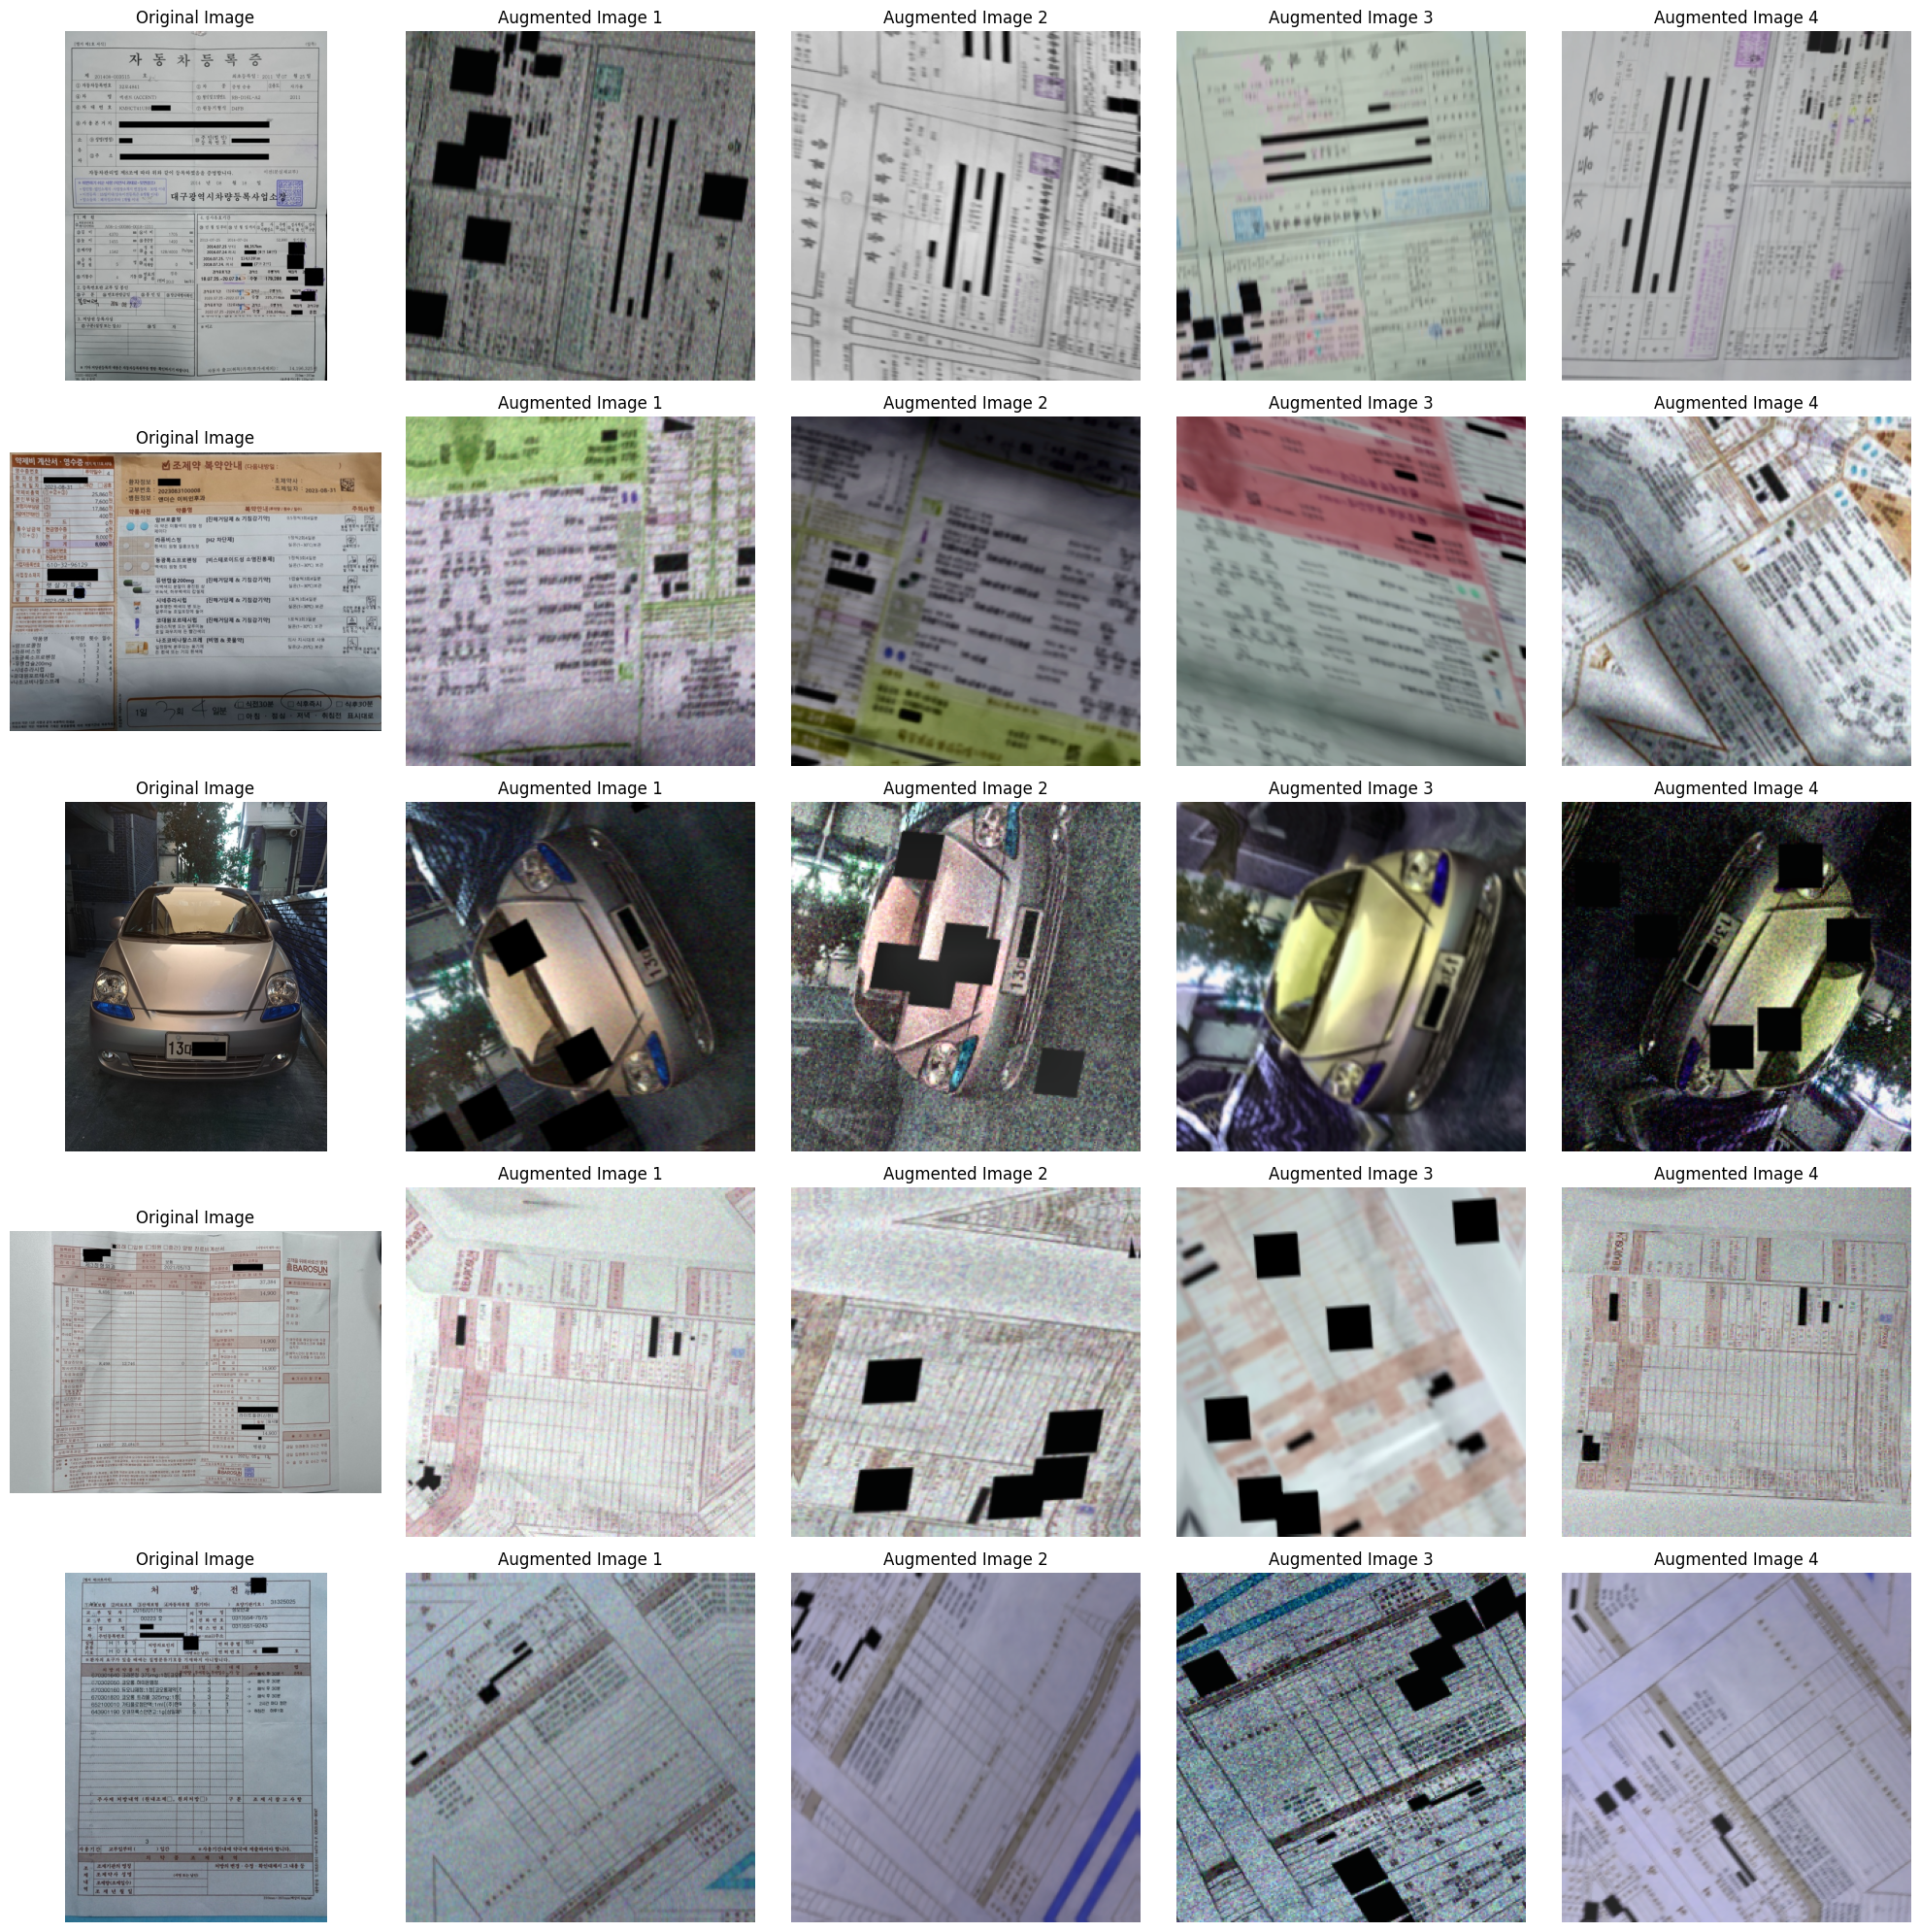

In [46]:

# 시각화 함수
def visualize_augmented_images(dataset, num_images=5, augmentations_per_image=4, data_gap=1570):
    fig, axes = plt.subplots(num_images, augmentations_per_image + 1, figsize=(20, num_images * 4))
    
    for i in range(num_images):
        # 원본 이미지 인덱스
        original_img_index = random.randint(0,ori_traindata_num)
        
        # 원본 이미지 로드
        original_img_path = os.path.join(dataset.path, dataset.df[original_img_index][0])
        original_img = np.array(Image.open(original_img_path))
        
        # 원본 이미지 표시
        axes[i, 0].imshow(original_img)
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis("off")
        
        # 증강된 이미지 최대 4개 표시
        for j in range(1, augmentations_per_image + 1):
            # 증강된 이미지를 올바르게 가져오기 위해, 증강 비율을 사용하여 인덱스를 계산
            augmented_idx = original_img_index + data_gap * (j - 1)
            augmented_img, _ = dataset[augmented_idx]
            augmented_img = augmented_img.permute(1, 2, 0).numpy()  # CHW -> HWC
            
            # Normalize 된 이미지를 다시 원래 범위로 변환
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            augmented_img = std * augmented_img + mean
            augmented_img = np.clip(augmented_img, 0, 1)
            
            axes[i, j].imshow(augmented_img)
            axes[i, j].set_title(f"Augmented Image {j}")
            axes[i, j].axis("off")
    
    plt.tight_layout()
    plt.show()

# 트레이닝 데이터 시각화
visualize_augmented_images(trn_dataset)

In [47]:
len(trn_dataset)

62800

In [48]:

trn_loader = DataLoader(
    trn_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False
)

tst_loader = DataLoader(
    tst_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)


In [49]:

# 모델을 불러옵니다.
model = timm.create_model(
    model_name,
    pretrained=True,
    num_classes=17,
    drop_rate=0.2  # Dropout 설정
).to(device)

# 손실 함수를 정의합니다.
loss_fn = nn.CrossEntropyLoss()

# 옵티마이저를 정의합니다.
optimizer = AdamW(model.parameters(), lr=LR)

# Learning Rate Scheduler를 정의합니다.
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Early Stopping을 위한 변수 초기화
best_loss = float('inf')
early_stopping_counter = 0


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnet_b3.ra2_in1k)
INFO:timm.models._hub:[timm/efficientnet_b3.ra2_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (classifier.weight, classifier.bias) discovered while loading pretrained weights. This is expected if model is being adapted.
c:\Users\sarak\.conda\envs\cv\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [50]:
# 한 에폭(epoch) 동안 모델을 학습시키는 함수입니다.
def train_one_epoch(loader, model, optimizer, loss_fn, device, log_interval=1000):
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []

    pbar = tqdm(loader)
    for batch_idx, (image, targets) in enumerate(pbar):
        if image is None or targets is None:
            continue
        
        image = image.to(device)
        targets = targets.to(device)

        optimizer.zero_grad(set_to_none=True)

        preds = model(image)
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

        # 지정된 간격으로만 wandb에 로그를 남김
        if batch_idx % log_interval == 0:
            wandb.log({
                "batch_loss": loss.item(),
                "cumulative_loss": train_loss / (batch_idx + 1)
            })

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    ret = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
    }

    # 에폭 단위로 wandb에 학습 과정 로그
    wandb.log({"train_loss": train_loss, "train_acc": train_acc, "train_f1": train_f1})

    return ret


In [51]:
torch.cuda.empty_cache()
# 학습 과정을 저장할 리스트 초기화
train_losses = []
train_accuracies = []
train_f1_scores = []

# 모델 학습 루프
for epoch in range(EPOCHS):
    ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device=device)
    ret['epoch'] = epoch

    # 학습 결과를 저장
    train_losses.append(ret["train_loss"])
    train_accuracies.append(ret["train_acc"])
    train_f1_scores.append(ret["train_f1"])

    log = ""
    for k, v in ret.items():
        log += f"{k}: {v:.4f}\n"
    print(log)

    # Scheduler 업데이트
    scheduler.step(ret["train_loss"])

    # Early Stopping 체크
    if ret["train_loss"] < best_loss:
        best_loss = ret["train_loss"]
        early_stopping_counter = 0
        # 모델 체크포인트 저장
        torch.save(model.state_dict(), f"{model_name}_{img_size}SIZE_{BATCH_SIZE}BATCH_{EPOCHS}EPOCH_{augment_ratio}AUG_best_model.pth")
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break


Loss: 0.2597: 100%|██████████| 3925/3925 [24:40<00:00,  2.65it/s]


train_loss: 0.3283
train_acc: 0.8832
train_f1: 0.8755
epoch: 0.0000



Loss: 0.6801:  62%|██████▏   | 2448/3925 [15:24<10:19,  2.39it/s]

In [ ]:

# 테스트 데이터에 대한 예측 수행
preds_list = []

model.eval()
for image, _ in tqdm(tst_loader):
    image = image.to(device)
    with torch.no_grad():
        preds = model(image)
    preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())

# 예측 결과를 데이터프레임으로 저장
pred_df = pd.DataFrame(tst_dataset.df, columns=['ID', 'target'])
pred_df['target'] = preds_list

# 제출 형식 파일을 읽어와 ID 열이 일치하는지 확인
sample_submission_df = pd.read_csv("datasets_fin/sample_submission.csv")
assert (sample_submission_df['ID'] == pred_df['ID']).all()

# 예측 결과를 CSV 파일로 저장
pred_df.to_csv(f"{model_name}_{img_size}SIZE_{BATCH_SIZE}BATCH_{EPOCHS}EPOCH_{augment_ratio}AUG_pred.csv", index=False)
print(pred_df.head())


100%|██████████| 197/197 [00:03<00:00, 56.46it/s]


                     ID  target
0  0008fdb22ddce0ce.jpg       2
1  00091bffdffd83de.jpg      12
2  00396fbc1f6cc21d.jpg       5
3  00471f8038d9c4b6.jpg      12
4  00901f504008d884.jpg       2


wandb: ERROR Error while calling W&B API: run 43g7tv6t was previously created and deleted; try a new run name (<Response [409]>)
wandb: ERROR Error while calling W&B API: run 43g7tv6t was previously created and deleted; try a new run name (<Response [409]>)
wandb: ERROR Error while calling W&B API: run 43g7tv6t was previously created and deleted; try a new run name (<Response [409]>)
wandb: ERROR Error while calling W&B API: run 43g7tv6t was previously created and deleted; try a new run name (<Response [409]>)
wandb: ERROR Error while calling W&B API: run 43g7tv6t was previously created and deleted; try a new run name (<Response [409]>)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Error while calling W&B API: run 43g7tv6t was previously created and deleted; try a new run name (<Response [409]>)
wandb: ERROR Error while calling W&B API: run 43g7tv6t was previously created and deleted; try a new run name (<Response [409]>)
wandb: ERROR Control-C d

KeyboardInterrupt: 

wandb: ERROR Error while calling W&B API: run 43g7tv6t was previously created and deleted; try a new run name (<Response [409]>)
Thread SenderThread:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/wandb/apis/normalize.py", line 41, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/wandb/sdk/internal/internal_api.py", line 2224, in upsert_run
    response = self.gql(
  File "/opt/conda/lib/python3.10/site-packages/wandb/sdk/internal/internal_api.py", line 317, in gql
    ret = self._retry_gql(
  File "/opt/conda/lib/python3.10/site-packages/wandb/sdk/lib/retry.py", line 131, in __call__
    result = self._call_fn(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/wandb/sdk/internal/internal_api.py", line 345, in execute
    return self.client.execute(*args, **kwargs)  # type: ignore
  File "/opt/conda/lib/python3.10/site-packages/wandb/vendor/gql-0.2.0/wandb_gql/client.py", line 52, in execute
  

In [ ]:

# wandb 실행 종료
wandb.finish()


In [ ]:

# 학습 손실 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss Over Epochs')
plt.legend()

# 학습 정확도 시각화
plt.subplot(1, 3, 2)
plt.plot(range(len(train_accuracies)), train_accuracies, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train Accuracy Over Epochs')
plt.legend()

# 학습 F1 점수 시각화
plt.subplot(1, 3, 3)
plt.plot(range(len(train_f1_scores)), train_f1_scores, label='Train F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Train F1 Score Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


---

In [ ]:

# # 모델 불러오기
# model = timm.create_model(model_name, pretrained=False, num_classes=17)
# model.load_state_dict(torch.load('efficientnet_b3.ra2_in1k_256SIZE_16BATCH_5EPOCH_200AUG_best_model.pth'))
# model.to(device)

# # 테스트 데이터에 대한 예측 수행
# preds_list = []

# model.eval()
# for image, _ in tqdm(tst_loader):
#     image = image.to(device)
#     with torch.no_grad():
#         preds = model(image)
#     preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())

# # 예측 결과를 데이터프레임으로 저장
# pred_df = pd.DataFrame(tst_dataset.df, columns=['ID', 'target'])
# pred_df['target'] = preds_list

# # 제출 형식 파일을 읽어와 ID 열이 일치하는지 확인
# sample_submission_df = pd.read_csv("datasets_fin/sample_submission.csv")
# assert (sample_submission_df['ID'] == pred_df['ID']).all()

# # 예측 결과를 CSV 파일로 저장
# pred_df.to_csv(f"{model_name}_{img_size}SIZE_{batch_size}BATCH_{epochs}EPOCH_{augment_ratio}AUG_pred.csv", index=False)
# print(pred_df.head())